# Proyek Klasifikasi Gambar: Animals-10
- **Nama:** Zidan Mubarak
- **Email:** zidanmubarak00@gmail.com
- **ID Dicoding:** zidanmubarak

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil
import glob
import random
import tensorflowjs as tfjs
from PIL import Image
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# mengatur seed untuk reproduksibilitas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## Data Preparation

### Data Loading

In [4]:
# mengupload dataset dari local
from google.colab import drive
drive.mount('/content/drive')

# path ke dataset animal-10
dataset_path = '/content/drive/MyDrive/dicoding/pengembangan ML/submission 2/Animals-10'

# kelas hewan yang dipilih
selected_classes = ['chicken', 'dog', 'horse']

Mounted at /content/drive


In [5]:
# verifikasi bahwa kelas yang dipilih ada di dataset
available_classes = os.listdir(dataset_path)
print("kelas yang tersedia di dataset:")
print(available_classes)
print("kelas yang dipilih untuk klasifikasi:")
print(selected_classes)

kelas yang tersedia di dataset:
['cow', 'cat', 'spider', 'horse', 'squirrel', 'dog', 'sheep', 'chicken', 'elephant', 'butterfly']
kelas yang dipilih untuk klasifikasi:
['chicken', 'dog', 'horse']


In [6]:
# membuat dataframe untuk data dan label
def create_dataframe_from_selected_classes(directory, classes):
  data = []
  for category in classes:
    category_dir = os.path.join(directory, category)
    if os.path.isdir(category_dir):
      for img_name in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img_name)
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
          data.append({
              'image_path': img_path,
              'label': category
          })

  return pd.DataFrame(data)

In [7]:
# membuat dataframe dari kelas yang dipilih
animals_df = create_dataframe_from_selected_classes(dataset_path, selected_classes)
print(f"\ntotal jumlah data: {len(animals_df)}")
print(animals_df['label'].value_counts())


total jumlah data: 10594
label
dog        4863
chicken    3098
horse      2633
Name: count, dtype: int64


In [8]:
# visualisasi sampel gambar dari setiap kelas yang dipilih
plt.figure(figsize=(15, 12))
for i, cls in enumerate(selected_classes):
  # ambil sampel gambar dari kelas
  class_samples = animals_df[animals_df['label'] == cls]['image_path'].sample(min(4, sum(animals_df['label'] == cls))).tolist()

  for j, img_path in enumerate(class_samples):
    img = plt.imread(img_path)
    plt.subplot(len(selected_classes), 4, i*4 + j +1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

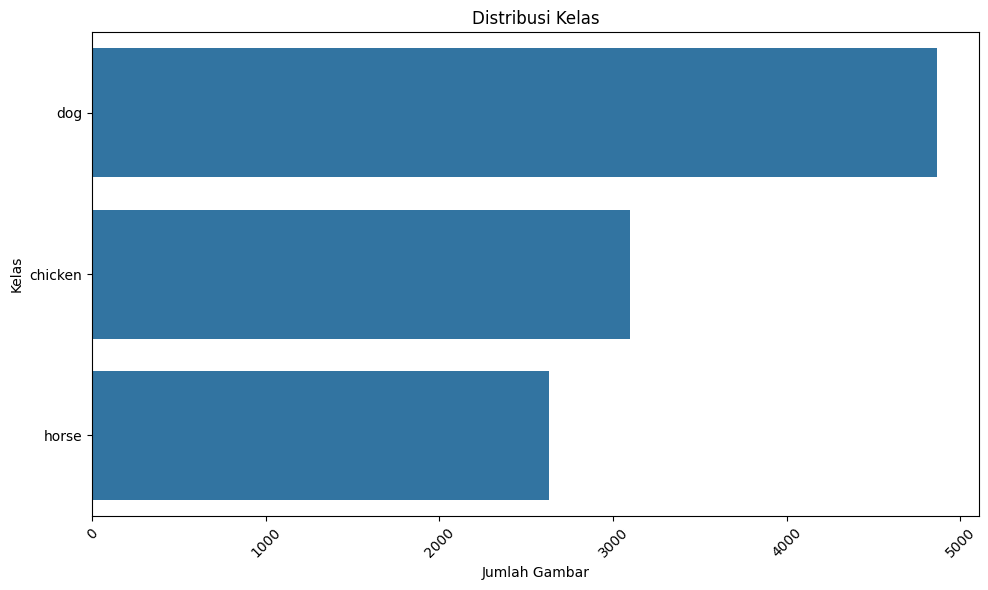

In [9]:
# visualisasi distribusi kelas
plt.figure(figsize=(10, 6))
sns.countplot(y='label', data=animals_df, order=animals_df['label'].value_counts().index)
plt.title('Distribusi Kelas')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Kelas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Verifikasi bahwa gambar memiliki resolusi yang tidak seragam (tanpa preprocessing)
print("\nMemeriksa resolusi gambar untuk membuktikan dataset memiliki resolusi tidak seragam:")
resolutions = []
sample_images = animals_df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)

for idx, row in sample_images.iterrows():
  img = Image.open(row['image_path'])
  width, height = img.size
  resolutions.append((width, height))
  print(f"kelas {row['label']}, gambar: {os.path.basename(row['image_path'])}, resolusi: {width}x{height}")


Memeriksa resolusi gambar untuk membuktikan dataset memiliki resolusi tidak seragam:


<ipython-input-10-623564962485>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_images = animals_df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)


kelas chicken, gambar: chicken (2430).jpeg, resolusi: 213x300
kelas dog, gambar: dog (4108).jpeg, resolusi: 300x240
kelas horse, gambar: horse (1).jpeg, resolusi: 300x225


In [11]:
# Cek apakah semua resolusi sama
is_uniform = len(set(resolutions)) == 1
print(f"\nApakah resolusi gambar seragam? {'Ya' if is_uniform else 'Tidak'}")
if not is_uniform:
    print("Dataset memiliki resolusi gambar yang tidak seragam, sesuai kriteria.")


Apakah resolusi gambar seragam? Tidak
Dataset memiliki resolusi gambar yang tidak seragam, sesuai kriteria.


In [12]:
# menghitung total gambar
total_images = len(animals_df)
print(f"\ntotal gambar dalam dataset yang dipilih: {total_images}")


total gambar dalam dataset yang dipilih: 10594


### Data Preprocessing

#### Split Dataset

In [13]:
# split data memjadi train, test, validation dengan stratifikasi
train_df, temp_df = train_test_split(animals_df, test_size=0.2, stratify=animals_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"train set: {len(train_df)} gambar")
print(f"test set: {len(test_df)} gambar")
print(f"validation set: {len(val_df)} gambar")

train set: 8475 gambar
test set: 1060 gambar
validation set: 1059 gambar


In [14]:
# memeriksa distribusi kelas di setiap set
print("\nDistribusi kelas pada train set:")
print(train_df['label'].value_counts())
print("\nDistribusi kelas pada validation set:")
print(val_df['label'].value_counts())
print("\nDistribusi kelas pada test set:")
print(test_df['label'].value_counts())


Distribusi kelas pada train set:
label
dog        3890
chicken    2478
horse      2107
Name: count, dtype: int64

Distribusi kelas pada validation set:
label
dog        486
chicken    310
horse      263
Name: count, dtype: int64

Distribusi kelas pada test set:
label
dog        487
chicken    310
horse      263
Name: count, dtype: int64


In [15]:
# mendefenisikan parameter
IMG_SIZE = 224 # ukuran gambar sesuai dengan model standar
BATCH_SIZE = 32
NUM_CLASSES = len(selected_classes)

# buat direktori untuk train, test, dan validation
output_base_dir = '/content/drive/MyDrive/dicoding/pengembangan ML/submission 2/animals_dataset_split'
train_output_dir = os.path.join(output_base_dir, 'train')
test_output_dir = os.path.join(output_base_dir, 'test')
val_output_dir = os.path.join(output_base_dir, 'validation')

# hapus direktori jika sudah ada untuk memastikan tidak ada data lama, kalau belum ada direkroti maka dibuat baru
if os.path.exists(output_base_dir):
  shutil.rmtree(output_base_dir)
# else:
#   os.makedirs(output_base_dir)

# buat direktori baru
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)
os.makedirs(val_output_dir, exist_ok=True)

In [16]:
# fungsi untuk menyalin gambar berdasarkan dataframe
def copy_images_simple(df, output_dir):
    # Buat semua folder kelas
    unique_labels = df['label'].unique()
    for label in unique_labels:
        os.makedirs(os.path.join(output_dir, label), exist_ok=True)

    for row in tqdm(df.itertuples(index=False), total=len(df), desc=f"Menyalin ke {os.path.basename(output_dir)}"):
        src_path = row.image_path
        dst_path = os.path.join(output_dir, row.label, os.path.basename(src_path))

        # salin gambar ke direktori baru
        shutil.copyfile(src_path, dst_path)

# salin gambar ke direktori yang sesuai
copy_images_simple(train_df, train_output_dir)
copy_images_simple(test_df, test_output_dir)
copy_images_simple(val_df, val_output_dir)

Menyalin ke train:   0%|          | 0/8475 [00:00<?, ?it/s]

Menyalin ke test:   0%|          | 0/1060 [00:00<?, ?it/s]

Menyalin ke validation:   0%|          | 0/1059 [00:00<?, ?it/s]

In [17]:
# verifikasi bahwa gambar telah disalin dengan benar
print("\nJumlah gambar di direktori train:", sum([len(os.listdir(os.path.join(train_output_dir, cls))) for cls in os.listdir(train_output_dir)]))
print("Jumlah gambar di direktori validation:", sum([len(os.listdir(os.path.join(val_output_dir, cls))) for cls in os.listdir(val_output_dir)]))
print("Jumlah gambar di direktori test:", sum([len(os.listdir(os.path.join(test_output_dir, cls))) for cls in os.listdir(test_output_dir)]))


Jumlah gambar di direktori train: 8475
Jumlah gambar di direktori validation: 1059
Jumlah gambar di direktori test: 1060


#### Image Data Generator

In [18]:
# menggunakan imagedatagenerator untuk augmentasi data dan preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2] # variasi kecerahan
)

# minimal preprocessing untuk test dan validasi
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
# flow generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_output_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_output_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

validation_generator = validation_datagen.flow_from_directory(
    val_output_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8475 images belonging to 3 classes.
Found 1060 images belonging to 3 classes.
Found 1059 images belonging to 3 classes.


In [20]:
# mendapatkan clss indices
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print("class indices:", class_indices)

class indices: {'chicken': 0, 'dog': 1, 'horse': 2}


## Modelling

In [21]:
# Custom callback untuk menghentikan training jika akurasi melebihi threshold
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=0.96):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        if accuracy is not None and accuracy >= self.threshold:
            print(f"\nAkurasi mencapai {accuracy:.4f}, melebihi threshold {self.threshold}. Menghentikan pelatihan.")
            self.model.stop_training = True

In [22]:
# Model untuk klasifikasi hewan
model = Sequential([
    # layer pertama
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # layer kedua
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # layer ketiga
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # layer keempat
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # layer kelima
    Flatten(),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax') # 11 kelas
])

# compile model
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 107,987,011 (411.94 MB)

 Trainable params: 107,980,099 (411.91 MB)

 Non-trainable params: 6,912 (27.00 KB)

In [23]:
# implementasi callback
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, monitor='val_loss'),
    ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_accuracy'),
    AccuracyThresholdCallback(threshold=0.96)
]

In [24]:
# jumlah epoch
EPOCHS = 60

# melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
265/265 ━━━━━━━━━━━━━━━━━━━━ 189s 554ms/step - accuracy: 0.4369 - loss: 1.6009 - val_accuracy: 0.4806 - val_loss: 1.3174 - learning_rate: 0.0010
Epoch 2/60
265/265 ━━━━━━━━━━━━━━━━━━━━ 131s 483ms/step - accuracy: 0.5588 - loss: 1.0335 - val_accuracy: 0.6544 - val_loss: 0.8281 - learning_rate: 0.0010
Epoch 3/60
265/265 ━━━━━━━━━━━━━━━━━━━━ 130s 490ms/step - accuracy: 0.6326 - loss: 0.8709 - val_accuracy: 0.6752 - val_loss: 0.7508 - learning_rate: 0.0010
Epoch 4/60
265/265 ━━━━━━━━━━━━━━━━━━━━ 129s 477ms/step - accuracy: 0.6897 - loss: 0.7617 - val_accuracy: 0.6874 - val_loss: 0.7416 - learning_rate: 0.0010
Epoch 5/60
265/265 ━━━━━━━━━━━━━━━━━━━━ 127s 480ms/step - accuracy: 0.7427 - loss: 0.6415 - val_accuracy: 0.7271 - val_loss: 0.6695 - learning_rate: 0.0010
Epoch 6/60
265/265 ━━━━━━━━━━━━━━━━━━━━ 123s 465ms/step - accuracy: 0.7775 - loss: 0.5753 - val_accuracy: 0.7158 - val_loss: 0.9752 - learning_rate: 0.0010
Epoch 7/60
265/265 ━━━━━━━━━━━━━━━━━━━━ 121s 456ms/step - accura

## Evaluasi dan Visualisasi

In [25]:
# Mengevaluasi model pada training set
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training accuracy: {train_acc:.4f}")
print(f"Training loss: {train_loss:.4f}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 120s 453ms/step - accuracy: 0.9836 - loss: 0.0570
Training accuracy: 0.9819
Training loss: 0.0604


In [30]:
# Mengevaluasi model pada test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9398 - loss: 0.1606
Test accuracy: 0.9415
Test loss: 0.1535


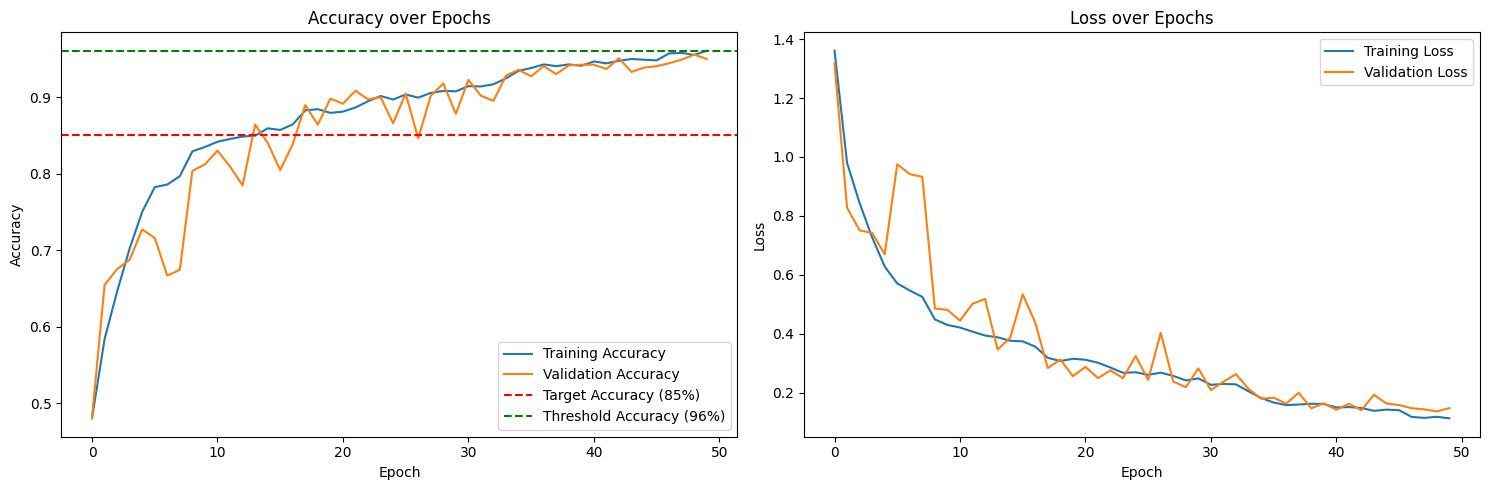

In [31]:
# plot akurasi
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=0.85, color='r', linestyle='--', label='Target Accuracy (85%)')
plt.axhline(y=0.96, color='g', linestyle='--', label='Threshold Accuracy (96%)')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step


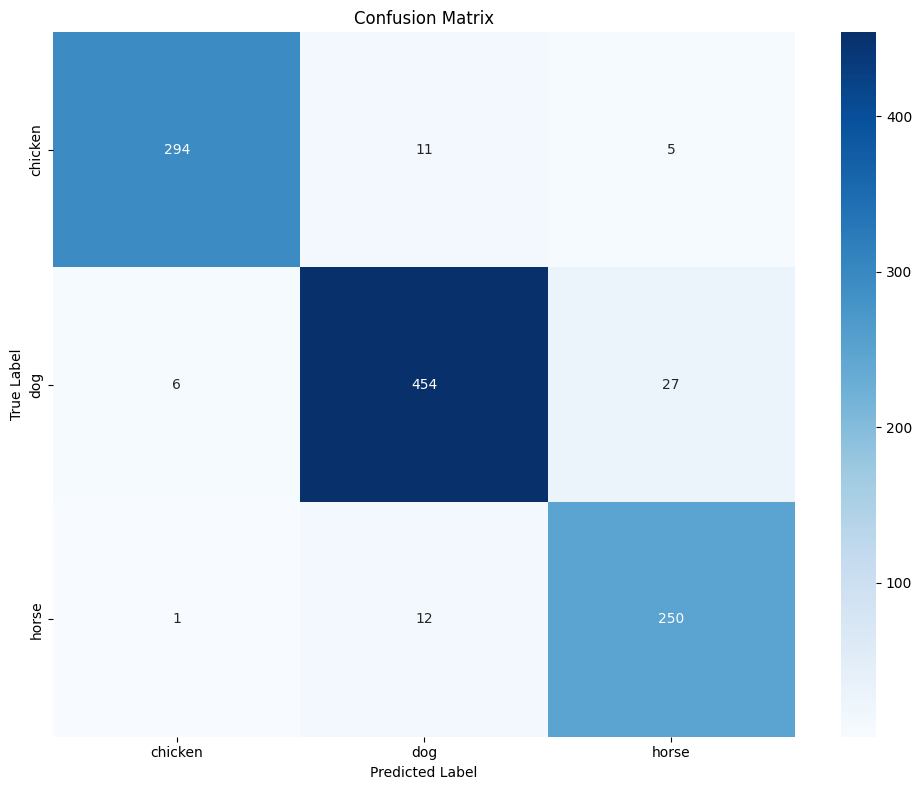

In [32]:
# mendapatkan prediksi dan ground truth
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Membuat confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [33]:
# laporan klasifikasi detail
print("\nLaporan Klasifikasi Detail:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Laporan Klasifikasi Detail:
              precision    recall  f1-score   support

     chicken       0.98      0.95      0.96       310
         dog       0.95      0.93      0.94       487
       horse       0.89      0.95      0.92       263

    accuracy                           0.94      1060
   macro avg       0.94      0.94      0.94      1060
weighted avg       0.94      0.94      0.94      1060



## Konversi Model

In [39]:
# Pastikan direktori yang diperlukan sudah ada
base_dir = '/content/drive/MyDrive/dicoding/pengembangan ML/submission 2'
os.makedirs(f'{base_dir}/saved_model', exist_ok=True)
os.makedirs(f'{base_dir}/tfjs_model', exist_ok=True)
os.makedirs(f'{base_dir}/tflite', exist_ok=True)

In [40]:
# 1. Menyimpan model dalam format SavedModel
tf.saved_model.save(model, f'{base_dir}/saved_model')
print("Model telah disimpan dalam format SavedModel.")

# 2. Menyimpan model dalam format Tensorflow.js
tfjs.converters.save_keras_model(model, f'{base_dir}/tfjs_model')
print("Model telah disimpan dalam format Tensorflow.js.")

# 3. Menyimpan model dalam format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(f'{base_dir}/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

with open(f'{base_dir}/tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

print("Model telah disimpan dalam format Tensorflow Lite.")

Model telah disimpan dalam format SavedModel.
failed to lookup keras version from the file,
    this is likely a weight only file
Model telah disimpan dalam format Tensorflow.js.
Saved artifact at '/tmp/tmpcljmkxda'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135911416585232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135911416583504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135911416592144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135911416585808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135911416592336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135911416585616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135911416587152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135911416587728: TensorSpec(shape=(), dtype=t

## Inference (Optional)

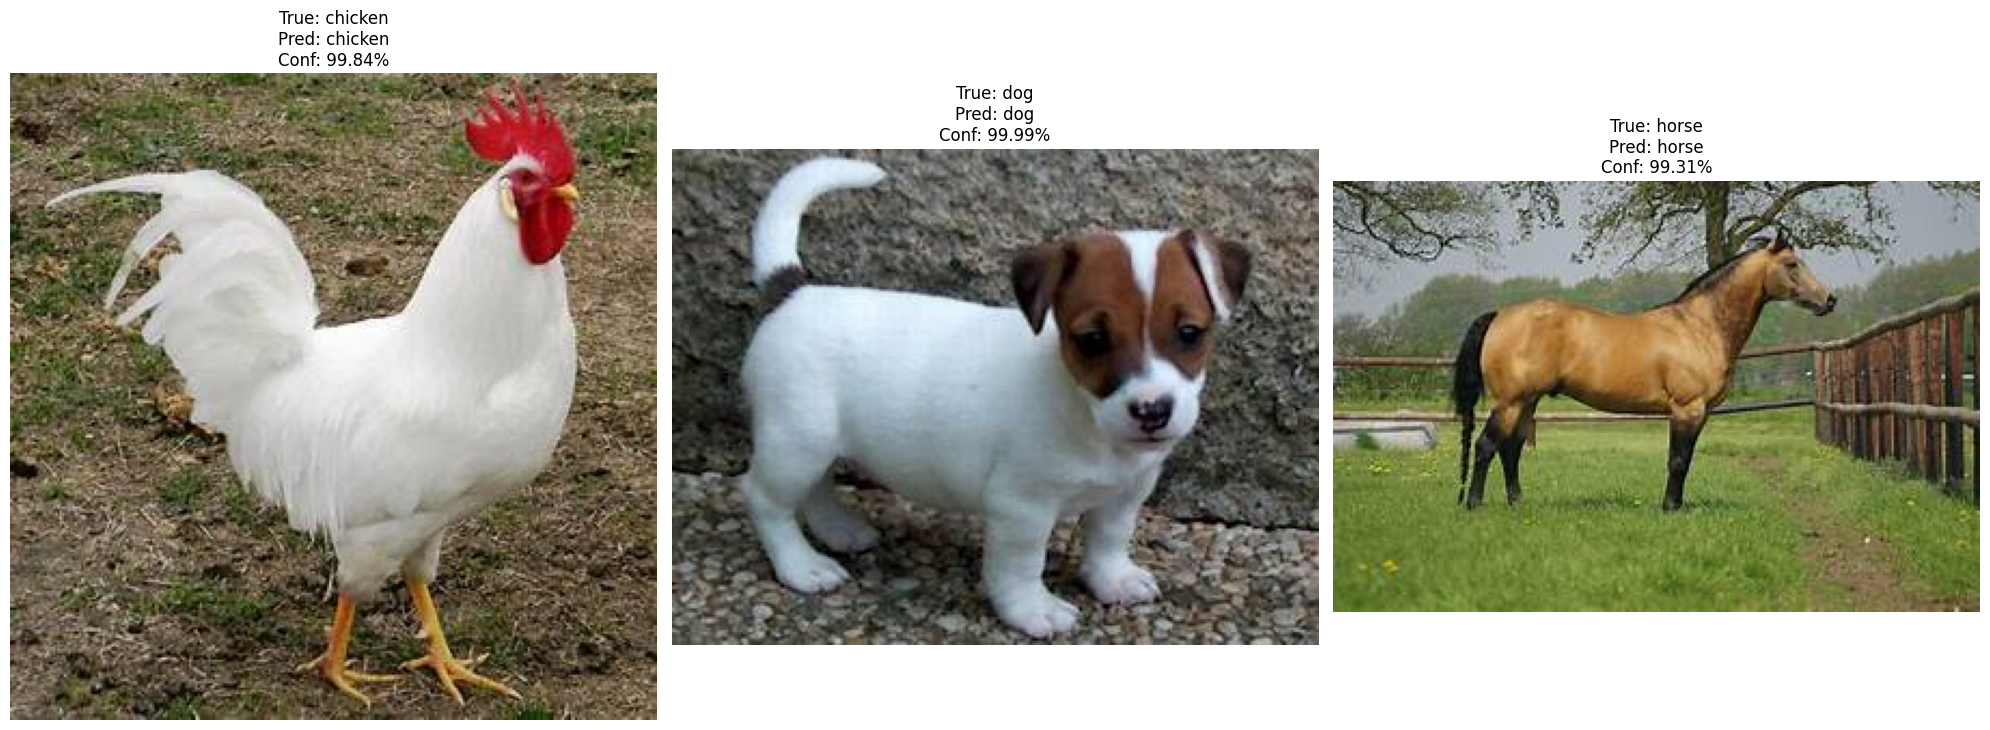

In [44]:
from keras.layers import TFSMLayer

# Menggunakan TFSMLayer untuk inferensi dari SavedModel
model = TFSMLayer(f'{base_dir}/saved_model', call_endpoint='serving_default')

# Fungsi preprocessing
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return np.expand_dims(img, axis=0)

# Daftar path gambar yang ingin diuji
test_image_paths = [
    '/content/drive/MyDrive/dicoding/pengembangan ML/submission 2/animals_dataset_split/test/chicken/chicken (89).jpeg',
    '/content/drive/MyDrive/dicoding/pengembangan ML/submission 2/animals_dataset_split/test/dog/dog (286).jpeg',
    '/content/drive/MyDrive/dicoding/pengembangan ML/submission 2/animals_dataset_split/test/horse/horse (78).jpeg'
]

# Melakukan inferensi menggunakan model SavedModel
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(test_image_paths):
    img = preprocess_image(img_path)
    prediction = model(img)  # Pakai model TFSMLayer langsung
    prediction = prediction['output_0']
    prediction = prediction.numpy()

    # Prediksi
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    # Menampilkan gambar dan hasil prediksi
    original_img = plt.imread(img_path)
    plt.subplot(1, len(test_image_paths), i + 1)
    plt.imshow(original_img)
    true_class = img_path.split('/')[-2]
    plt.title(f"True: {true_class}\nPred: {predicted_class}\nConf: {confidence:.2f}%")
    plt.axis('off')

plt.tight_layout()
plt.savefig(f'{base_dir}/savedmodel_inference.png')
plt.show()
